<a href="https://colab.research.google.com/github/CamH53/DiabetesDatasetTool/blob/main/LogisticModel_(Hasan).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Goal:**
Create a Machine learning model that uses the features to generate a prediction for the readmittance level of a person. Find what factors are the most influential in producing a prediction.

**1. Pre-Processing:**
Normalization of Numerical Data and One-Hot Encoding for Categorical Data

**2. Feature Engineering and Complexity**

Interaction Effects (2nd Level)

Random Forest (2nd)




**First Model: Logistic Regression (Elastic Net)**

Interaction Effects will be left for another analysis

**Additional Project Imports**


*   sklearn was the main machine learning library I used for this project. The documentation was clearly written and even though I was not experienced with it, the library provided the lowest barrier of entry from my previous knowledge.


In [ ]:
# 1. Load what we will need for data wrangling, visualization, and modeling
from google.colab import drive
import numpy as np
import pandas as pd
import pickle
import csv

pd.options.display.max_rows = None
pd.options.display.max_columns = None

# For visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


#for modeling
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_selector as selector
from sklearn.model_selection import train_test_split as tts
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, f1_score


In [ ]:
# 1.1 . Add my Google Drive
drive.mount('/content/gdrive')

# 1.2 . Go to folder on Google Drive that contains files
%cd /content/gdrive/MyDrive/CDC2023/

# 1.3 . Special shell command to view the files in the home directory of the notebook environment
!ls


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/CDC2023
'CategoricalDescriptiveAnalysis(Cam).ipynb'   HealthSciences_Dataset.csv
 CDC2023.gdoc				     'LogisticModel (Hasan).ipynb'
'CDC 2023 Slideshow .gslides'		     'NumericalDescriptiveAnalysis(Hasan).ipynb'
'CleanandWrangle(Both).ipynb'		     'RandomForest (Hasan).ipynb'
 diabetes_clean.csv


In [ ]:
diabetes_df = pd.read_csv('diabetes_clean.csv')

print(diabetes_df.columns)

Index(['Unnamed: 0', 'encounter_id', 'patient_nbr', 'race', 'gender', 'age',
       'weight', 'admission_type_id', 'discharge_disposition_id',
       'admission_source_id', 'time_in_hospital', 'payer_code',
       'medical_specialty', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'diag_1', 'diag_2', 'number_diagnoses',
       'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide',
       'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide',
       'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
       'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton',
       'insulin', 'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted',
       'age_num'],
      dtype='object')


**1.Pre-Processing Data**

To run any kind of model we need both normalized numerical variables so they can be compared for their impact on prediction later and one-hot encoding for categorical variables so that they can be analyzed.

In [ ]:
#Normalization of Data for Feature Importance
#time_in_hospital, num_lab_procedures, num_procedures, num_medications, number_outpatient, number_emergency, number_inpatient, number_diagnoses, age_num

df_z = diabetes_df[['time_in_hospital', 'num_lab_procedures', 'num_medications',
                          'number_outpatient', 'number_emergency', 'number_inpatient',
                          'number_diagnoses', 'age_num']].copy()

scaler = StandardScaler() #Normalizes values
df_z_scaled= pd.DataFrame(scaler.fit_transform(df_z), columns=df_z.columns)

print(df_z_scaled.columns)
print(df_z_scaled.shape)

#One-Hot Encoding

# Choose Categorical columns
#Create a Two Class Classification:
new_col = []
for value in diabetes_df['readmitted']:
  if value == '<30':
    new_col.append(True)
  else:
    new_col.append(False)

diabetes_df['readmit_new']= new_col #Make readmitted into two outcomes rather than 3.

categorical_columns_selector = selector(dtype_include = object) #Automate choosing categorical columns
categorical_columns = categorical_columns_selector(diabetes_df)

#Specific variables that are not relevant for analysis or are not complete
categorical_columns.remove('weight')
categorical_columns.remove('readmitted')
categorical_columns.remove('payer_code')
categorical_columns.remove('diag_1')
categorical_columns.remove('diag_2')

df_categorical = diabetes_df[categorical_columns].copy()
encoder = preprocessing.OneHotEncoder(sparse_output = False) . set_output(transform = 'pandas') #create all categorical variables into ones and zeroes and output into pandas df
df_encoded = pd.DataFrame(encoder.fit_transform(df_categorical))
print(df_encoded.shape)

df_clean = pd.concat([df_z_scaled, df_encoded], axis = 1)
print(df_clean.shape)



Index(['time_in_hospital', 'num_lab_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient',
       'number_diagnoses', 'age_num'],
      dtype='object')
(51817, 8)
(51817, 170)
(51817, 178)


**1.5 Train-Validation-Test Split**

All models have to be trained on one set of data, compared on a "new" set of data, and tested on a separate set of data so that we can avoid overfitting and biased values. Thus, since the final dataset is approximately 50,000 values, a train-validation-test split was used. Normally CV is used to choose features and compare models, but since we can create a comprehensive validation split, it is the most unbiased result.

Code inspired by: https://datascience.stackexchange.com/questions/15135/train-test-validation-set-splitting-in-sklearn

In [ ]:

# Define 60% 20% 20% Training Validation Test Split
labels = diabetes_df['readmit_new']

X_train_temp, X_test, y_train_temp, y_test = tts(df_clean, labels, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = tts(X_train_temp, y_train_temp, test_size=0.2, random_state=42)


**Elastic Net Logistic Regression**

After all of the one-hot encoding and normalization, there is approximately 178 variables to analyze. This is obviously too much for a logistic regression model and will undoubtedly cause overfitting, thus we have to use a feature selection technique to maximize some parameter while reducing the model. Since regularization feature selection also produces unbiased parameters that can be used for feature importance, an elastic net logistic regression model is chosen.

The below model sybmolically represents an elastic net logistic regression.
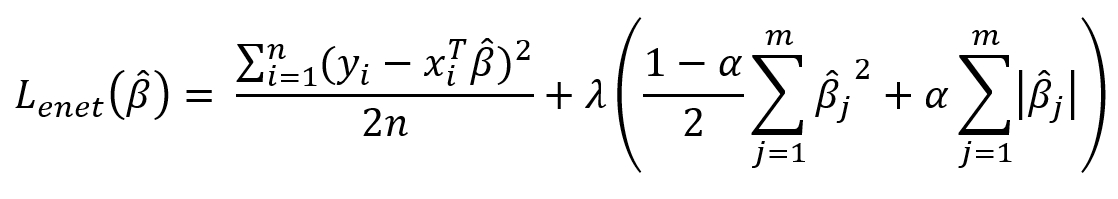
Link to Equation: https://subscription.packtpub.com/book/data/9781838556334/4/ch04lvl1sec52/elastic-net-regression

This shows that the elastic net logistic regression includes both the square of the paramter aswell as the absolute value (including the ridge and lasso effects) during optimization. Thus, among the parameters that can be changed is alpha or in sklearn 'l1_ratio', which we can create an array that can check each alpha value in the validation set while comparing them.

The metric that will be used to compare logistic regression models was the AUC.

Code inspired by: https://machinelearningmastery.com/elastic-net-regression-in-python/


Code inspired by: https://saturncloud.io/blog/using-explicit-predefined-validation-set-for-grid-search-with-scikitlearn/

In [ ]:
# Define Elastic Net Logistic Regression Model
# Assisted with GPT

# Define the parameter grid for the grid search
param_grid = {
    'l1_ratio': [0, 0.25, 0.5, 0.75, 1],
}

best_AUC = 0.0
best_hyperparameters = None

In [ ]:
# Hyperparameter tuning loop

for l1_ratio in param_grid['l1_ratio']:
        model = LogisticRegression(penalty='elasticnet', solver='saga', max_iter = 100000, l1_ratio=l1_ratio)
        model.fit(X_train, y_train)
        y_val_pred = model.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_val_pred)

        if auc > best_AUC:
            best_AUC = auc
            best_hyperparameter = {'l1_ratio': l1_ratio}


In [ ]:
# Train the final model using the best hyperparameters on the combined training and validation sets
final_model = LogisticRegression(penalty='elasticnet', solver='saga', max_iter=100000, **best_hyperparameter)
final_model.fit(X_test, y_test)

# Evaluate the final model on the test set
y_test_pred = final_model.predict_proba(X_test)[:, 1]
test_auc = roc_auc_score(y_test, y_test_pred)

print("L1 Ratio:", best_hyperparameter)
print("Test AUC:", test_auc)

L1 Ratio: {'l1_ratio': 1}
Test AUC: 0.6777799022634219


Since the AUC is about 0.68, the logistic regression is essentially a little bit better than a coin flip...

Thus, we need a model with increased complexity and we introduce the random forest.

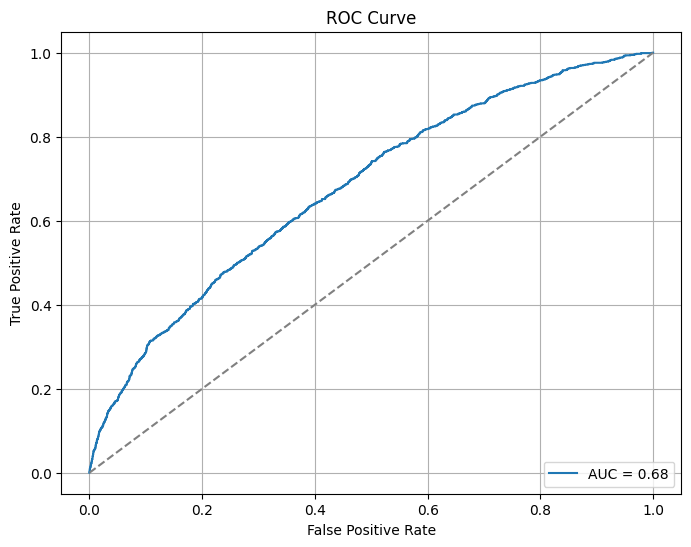

In [ ]:
# Calculate the ROC curve
fpr, tpr, ts = roc_curve(y_test, y_test_pred)  # Use y_proba[:, 1] for the positive class probabilities

# Calculate the AUC score
auc_score = roc_auc_score(y_test, y_test_pred)  # Use y_proba[:, 1] for the positive class probabilities

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Plot the diagonal line for reference
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()